In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc, animation
from matplotlib.lines import Line2D
from IPython.display import HTML, display, Image
import pandas as pd
import math
import datetime
import numpy as np
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('energy_demand.txt')

In [3]:
df.head()

,C,NEMP.WORLD,LFCST_HISTDEMAND,AEMO,PUBLIC,2018/12/02,02:00:00,0000000301717790,Unnamed: 8,0000000301717789
0,I,DEMAND,HISTORIC,1,REGIONID,SETTLEMENTDATE,PERIODID,DEMAND,NaN,NaN
1,D,DEMAND,HISTORIC,1,NSW1,2018/12/01 00:00:00,1,7083,NaN,NaN
2,D,DEMAND,HISTORIC,1,NSW1,2018/12/01 00:00:00,2,6858,NaN,NaN
3,D,DEMAND,HISTORIC,1,NSW1,2018/12/01 00:00:00,3,6600,NaN,NaN
4,D,DEMAND,HISTORIC,1,NSW1,2018/12/01 00:00:00,4,6354,NaN,NaN


In [4]:
# drop useless columns
df = df.drop([df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[-2], df.columns[-1]], axis='columns')

In [5]:
df.head()

,PUBLIC,2018/12/02,02:00:00,0000000301717790
0,REGIONID,SETTLEMENTDATE,PERIODID,DEMAND
1,NSW1,2018/12/01 00:00:00,1,7083
2,NSW1,2018/12/01 00:00:00,2,6858
3,NSW1,2018/12/01 00:00:00,3,6600
4,NSW1,2018/12/01 00:00:00,4,6354


In [6]:
# rename columns
df = df.rename(columns={'PUBLIC':'REGION', '2018/12/02':'DATE', '02:00:00':'HOUR', '0000000301717790':'MW'})

In [7]:
# remove dirty rows
df = df[df.REGION != 'REGION']
df = df[df.REGION != 'PUBLIC']
df = df[df.HOUR != 'HOUR']
df = df[df.MW != 'DEMAND']
df = df.dropna()

In [8]:
# convert columns from str to int
df['HOUR'] = df['HOUR'].astype(int)
df['HOUR'] = df['HOUR']/2
df['MW'] = df['MW'].astype(int)

In [9]:
# convert DATE from str to DATETIME
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y/%m/%d %H:%M:%S')

In [10]:
# split into state df
NSW = df.loc[df['REGION'] == 'NSW1']
QLD = df.loc[df['REGION'] == 'QLD1']
SA = df.loc[df['REGION'] == 'SA1']
TAS = df.loc[df['REGION'] == 'TAS1']
VIC = df.loc[df['REGION'] == 'VIC1']

In [11]:
# sort by date and period
NSW = NSW.sort_values(by=['DATE', 'HOUR'])
QLD = QLD.sort_values(by=['DATE', 'HOUR'])
SA = SA.sort_values(by=['DATE', 'HOUR'])
TAS = TAS.sort_values(by=['DATE', 'HOUR'])
VIC = VIC.sort_values(by=['DATE', 'HOUR'])

#### Now to parse the surise and sunset times for 1/12/18 to 31/12/19

In [15]:
sun_times = open('melbourne_sunrise_sunset_times.txt', 'r', encoding='utf-8').read()

In [16]:
sun_times = sun_times.splitlines()

In [17]:
import re

In [18]:
def times_strip(row):
    times = row[2:25] # splice first part of string
    times = re.findall(r'\d:\d\d', times) # find times 
    srise, sset = times[0], times[1] # assign variables
    srise, sset = srise.split(':'), sset.split(':') # split into hours and minutes
    srise = list(map(int, srise)) # convert all numbers from str to int
    sset = list(map(int, sset)) # convert all numbers from str to int
    srise[1] = srise[1]/60 # covert minutes to hours
    sset[0], sset[1] = sset[0]+12, sset[1]/60 # convert hours to 24 time, minutes to hours
    srise, sset = sum(srise), sum(sset) # sum each time into one
    
    day_length = row[25:50] # splice part of string containing day length
    day_length = re.findall(r'\d{1,2}:\d\d:\d\d', day_length) # find time
    hour, minute, second = day_length[0].split(':')
    hour, minute, second = int(hour), int(minute), int(second)
    minute, second = minute/60, second/3600
    daylight_hours = hour + minute + second
    
    
    return srise, sset, daylight_hours

In [19]:
'''
for each day on the year, strip the sunrise and sunset times, 
convert to 24 decimal time and add to year_times list
'''
year_times = []
for row in sun_times:
    if len(row) != 0:
        day_times = times_strip(row)
        year_times.append(day_times)

#### By calculating the area under the demand vs time graph, we can find the total energy used in MWh between 12:00am and midnight. 

In [20]:
def area_under(x1, y1, x2, y2):
    if y1 < y2:
        triangle = 0.5*(x2-x1)*(y2-y1) # half base x height
        rectangle = (x2-x1) * y1
        area = triangle + rectangle
        return area
    elif y1 > y2:
        triangle = 0.5*(x2-x1)*(y1-y2) # half base x height
        rectangle = (x2-x1) * y2
        area = triangle + rectangle
        return area
    elif y1 == y2:
        area = (x2-x1) * y2
        return area

In [21]:
days_energy = []
hhour_energy = [0]
day_areas = []
length = len(VIC)
i = 0
while i < length-1:
    x1 = VIC['HOUR'].iloc[i]
    x2 = VIC['HOUR'].iloc[i+1]
    y1 = VIC['MW'].iloc[i]
    y2 = VIC['MW'].iloc[i+1]
    if x1 != 24:
        area = area_under(x1,y1,x2,y2)
        day_areas.append(area)
    elif x1 == 24:
        day = VIC['DATE'].iloc[i]
        daily_energy = sum(day_areas)
        days_energy.append(daily_energy)
        day_areas = []
        x1 = 0
        area = area_under(x1,y1,x2,y2)
        day_areas.append(area)
    hhour_energy.append(area)   
    i += 1

Average total energy used per day:

In [22]:
ave = sum(days_energy)/len(days_energy)
print(ave)

118162.06898734177


Plot of total energy used per day:

In [23]:
dates = pd.unique(VIC['DATE'])
# dates = dates[:-1]

d1 = datetime.datetime.strptime('01/12/18', '%d/%m/%y')
autumn = datetime.datetime.strptime('01/03/19', '%d/%m/%y')
winter = datetime.datetime.strptime('01/06/19', '%d/%m/%y')
spring = datetime.datetime.strptime('01/09/19', '%d/%m/%y')
summer = datetime.datetime.strptime('01/12/19', '%d/%m/%y')
d_last = datetime.datetime.strptime('29/12/19', '%d/%m/%y')

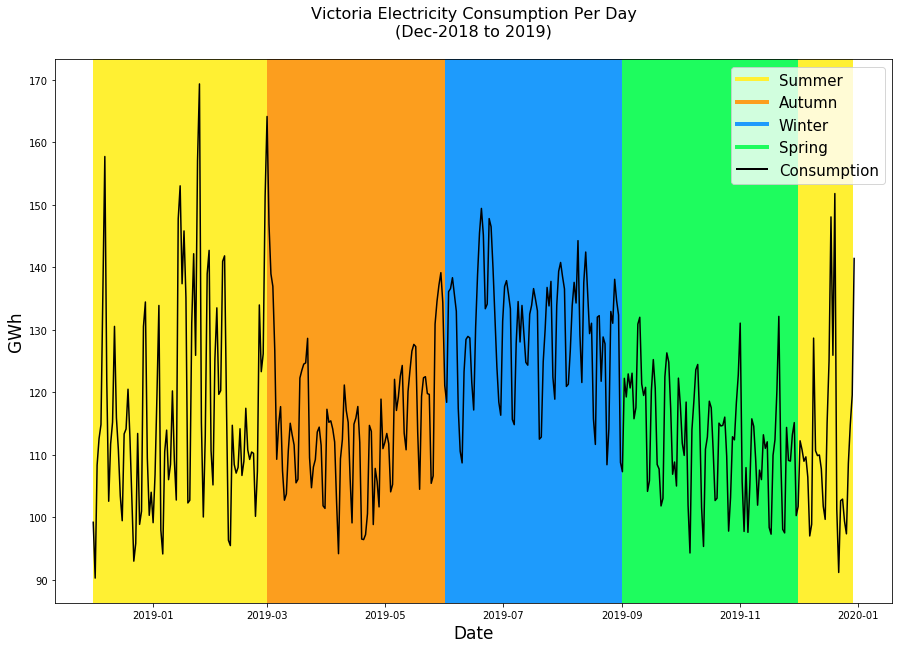

In [24]:
days_energy_GWh = [i/1000 for i in days_energy] # make list with GWh not MWh
plt.figure(figsize=(15,10))
plt.plot(dates[:-1], days_energy_GWh, color='black')
plt.title('Victoria Electricity Consumption Per Day\n(Dec-2018 to 2019)\n', size=16)
plt.xlabel('Date', size=17)
plt.ylabel('GWh', size=17)

plt.axvspan(d1, autumn, color='#FFF033')
plt.axvspan(autumn, winter, color='#FC9E1E')
plt.axvspan(winter, spring, color='#1E9BFC')
plt.axvspan(spring, summer, color='#1EFC5E')
plt.axvspan(summer, d_last, color='#FFF033')

legend_lines = [Line2D([0],[0], color='#FFF033', lw=4),
                Line2D([0],[0], color='#FC9E1E', lw=4),
                Line2D([0],[0], color='#1E9BFC', lw=4),
                Line2D([0],[0], color='#1EFC5E', lw=4), 
                Line2D([0],[0], color='black', lw=2)]
plt.legend(legend_lines, ['Summer', 'Autumn', 'Winter', 'Spring', 'Consumption'], prop={'size':15}, loc=1)
plt.savefig('VIC_daily_consumption')

Compute daylight hour energy demand

In [25]:
daytimes_energy = []
daytime_areas = []
length = len(VIC)
i = 0
j = 0
for i in range(length):
    if i+1 < length:
        x1 = VIC['HOUR'].iloc[i]
        x2 = VIC['HOUR'].iloc[i+1]
        y1 = VIC['MW'].iloc[i]
        y2 = VIC['MW'].iloc[i+1]
        sunset = year_times[j][1]
        sunrise = year_times[j][0]
        if x1 == 24:
            x1=0
            j += 1
        if x1 > sunrise and x2 < sunset:
            area = area_under(x1,y1,x2,y2)
            daytime_areas.append(area)
        elif x1 > sunset:
            if len(daytime_areas) > 0:
                d_energy = sum(daytime_areas)
                daytimes_energy.append(d_energy)
                daytime_areas = []
    i += 1
    print(i, end='\r')

Graph daylight energy demand per day

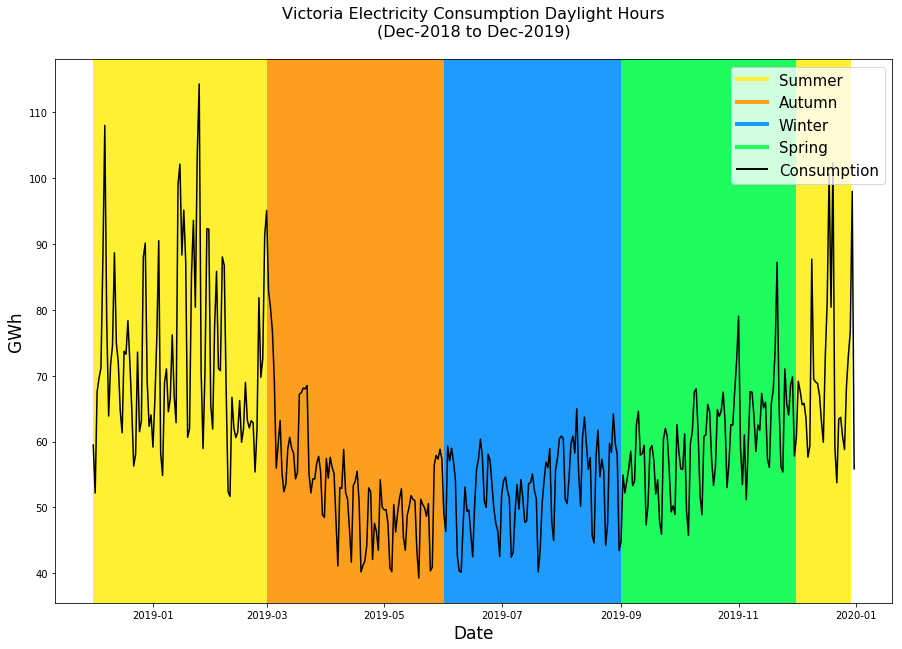

In [26]:
daytimes_energy_GWh = [i/1000 for i in daytimes_energy] # make list with GWh not MWh
dates = pd.unique(VIC['DATE'])
plt.figure(figsize=(15,10))
plt.plot(dates, daytimes_energy_GWh, color='black')
plt.title('Victoria Electricity Consumption Daylight Hours\n(Dec-2018 to Dec-2019)\n', size=16)
plt.xlabel('Date', size=17)
plt.ylabel('GWh', size=17)

plt.axvspan(d1, autumn, color='#FFF033')
plt.axvspan(autumn, winter, color='#FC9E1E')
plt.axvspan(winter, spring, color='#1E9BFC')
plt.axvspan(spring, summer, color='#1EFC5E')
plt.axvspan(summer, d_last, color='#FFF033')

legend_lines = [Line2D([0],[0], color='#FFF033', lw=4),
                Line2D([0],[0], color='#FC9E1E', lw=4),
                Line2D([0],[0], color='#1E9BFC', lw=4),
                Line2D([0],[0], color='#1EFC5E', lw=4), 
                Line2D([0],[0], color='black', lw=2)]
plt.legend(legend_lines, ['Summer', 'Autumn', 'Winter', 'Spring', 'Consumption'], prop={'size':15}, loc=1)
plt.savefig('VIC_daylight_consumption')

In [27]:
day_lengths = [i[2] for i in year_times]
day_lengths = pd.Series(day_lengths)
# day_lengths = day_lengths[]

Now to find the energy used between sunset and sunrise

In [28]:
nights_energy = []
night_areas = []
VIC_minus_half_first = VIC.iloc[24:] # drop first half of first day as I only have data for half that night
length = len(VIC)
i = 0
j = 0
for i in range(length):
    if i+1 < length and j+1 < len(year_times):
        x1 = VIC_minus_half_first['HOUR'].iloc[i]
        x2 = VIC_minus_half_first['HOUR'].iloc[i+1]
        y1 = VIC_minus_half_first['MW'].iloc[i]
        y2 = VIC_minus_half_first['MW'].iloc[i+1]
        sunset = year_times[j][1]
        sunrise = year_times[j+1][0]
        if x1 == 24:
            x1 = 0
        if x1 > sunset or x2 < sunrise:
            area = area_under(x1,y1,x2,y2)
            night_areas.append(area)
        elif x1 > sunrise:
            if len(night_areas) > 0:
                n_energy = sum(night_areas)
                nights_energy.append(n_energy)
                night_areas = []
                j += 1
        i += 1
    print(i, end='\r')

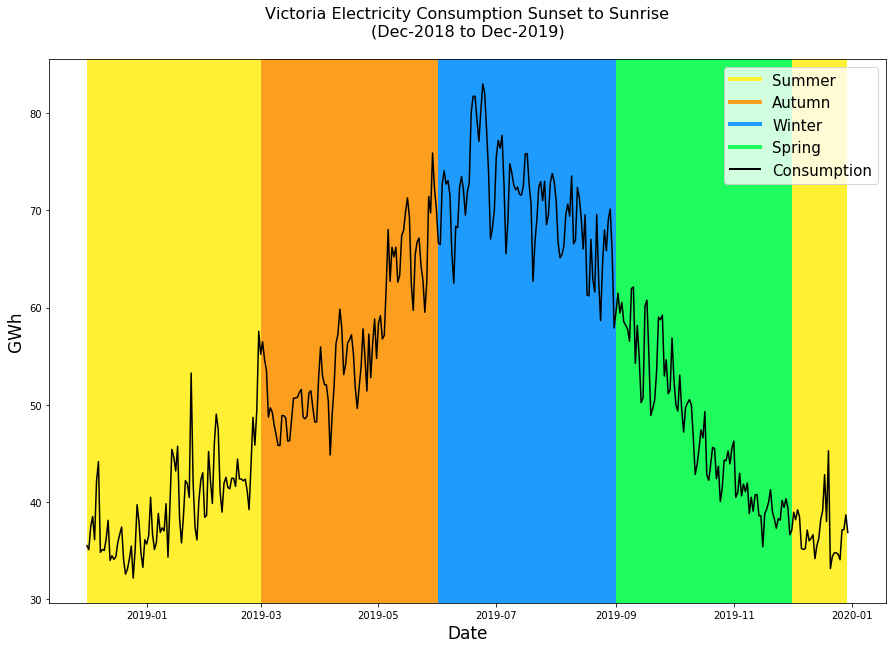

In [29]:
nights_energy_GWh = [i/1000 for i in nights_energy] # make list with GWh not MWh
plt.figure(figsize=(15,10))
plt.plot(dates[:-1], nights_energy_GWh, color='black')
plt.title('Victoria Electricity Consumption Sunset to Sunrise\n(Dec-2018 to Dec-2019)\n', size=16)
plt.xlabel('Date', size=17)
plt.ylabel('GWh', size=17)

plt.axvspan(d1, autumn, color='#FFF033')
plt.axvspan(autumn, winter, color='#FC9E1E')
plt.axvspan(winter, spring, color='#1E9BFC')
plt.axvspan(spring, summer, color='#1EFC5E')
plt.axvspan(summer, d_last, color='#FFF033')

legend_lines = [Line2D([0],[0], color='#FFF033', lw=4),
                Line2D([0],[0], color='#FC9E1E', lw=4),
                Line2D([0],[0], color='#1E9BFC', lw=4),
                Line2D([0],[0], color='#1EFC5E', lw=4), 
                Line2D([0],[0], color='black', lw=2)]
plt.legend(legend_lines, ['Summer', 'Autumn', 'Winter', 'Spring', 'Consumption'], prop={'size':15}, loc=1)
plt.savefig('VIC_night_consumption')

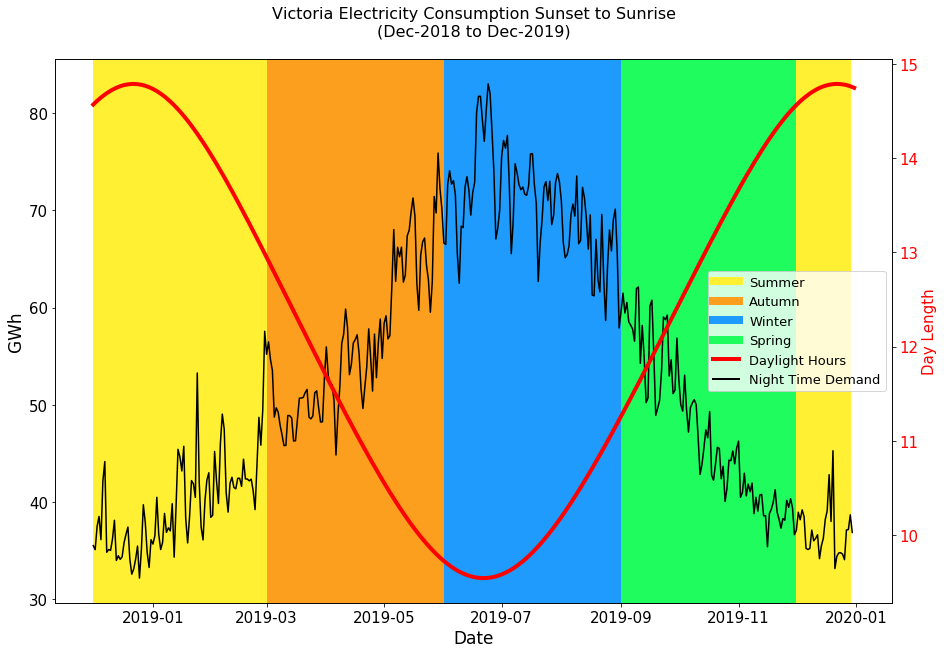

In [30]:
nights_energy_GWh = [i/1000 for i in nights_energy] # make list with GWh not MWh
fig, ax1 = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(dates[:-1], nights_energy_GWh, color='black')
ax1.set_title('Victoria Electricity Consumption Sunset to Sunrise\n(Dec-2018 to Dec-2019)\n', size=16)
ax1.set_xlabel('Date', size=17)
ax1.set_ylabel('GWh', size=17)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax1.axvspan(d1, autumn, color='#FFF033')
ax1.axvspan(autumn, winter, color='#FC9E1E')
ax1.axvspan(winter, spring, color='#1E9BFC')
ax1.axvspan(spring, summer, color='#1EFC5E')
ax1.axvspan(summer, d_last, color='#FFF033')

ax2 = ax1.twinx()

ax2.set_ylabel('Day Length', color='red', size=15)
ax2.plot(dates, day_lengths, color='red', lw=4)
ax2.tick_params(axis='y', labelcolor='red', labelsize=15)

legend_lines = [Line2D([0],[0], color='#FFF033', lw=8),
                Line2D([0],[0], color='#FC9E1E', lw=8),
                Line2D([0],[0], color='#1E9BFC', lw=8),
                Line2D([0],[0], color='#1EFC5E', lw=8),
                Line2D([0],[0], color='red', lw=4),
                Line2D([0],[0], color='black', lw=2)]
                       
ax1.legend(legend_lines, 
           ['Summer', 'Autumn', 'Winter', 'Spring', 'Daylight Hours', 'Night Time Demand'],
           loc=5, 
           prop={'size':13})
plt.savefig('VIC_night_consumption_daylength')

In [31]:
solar_energy = pd.read_csv('solar_exposure_melbourne.csv')

In [32]:
solar_energy.tail()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Daily global solar exposure (MJ/m*m)
11006,IDCJAC0016,86338,2020,2,19,12.9
11007,IDCJAC0016,86338,2020,2,20,15.2
11008,IDCJAC0016,86338,2020,2,21,17.1
11009,IDCJAC0016,86338,2020,2,22,25.4
11010,IDCJAC0016,86338,2020,2,23,21.6


In [33]:
# extract data for Dec 2018 to end of 2019
solar_energy = solar_energy.iloc[10561:10957] 

In [34]:
# rename column
solar_energy = solar_energy.rename(columns={'Daily global solar exposure (MJ/m*m)':'Solar'})

In [35]:
solar_energy = solar_energy.reset_index()

In [36]:
# nights_energy.append(0)

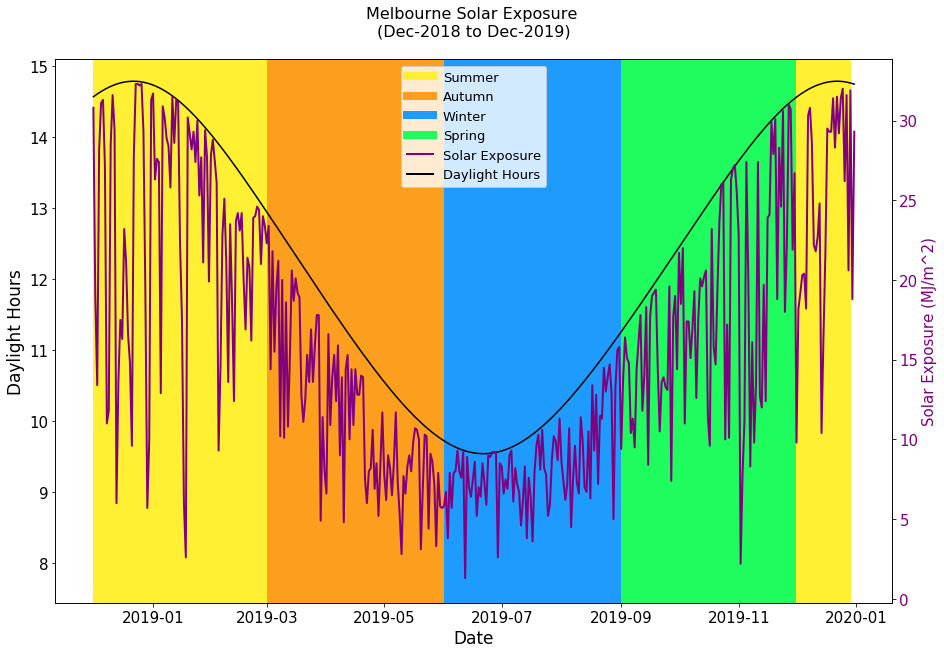

In [37]:
fig, ax1 = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)


ax1.plot(dates, day_lengths, color='black')
ax1.set_title('Melbourne Solar Exposure \n(Dec-2018 to Dec-2019)\n', size=16)
ax1.set_xlabel('Date', size=17)
ax1.set_ylabel('Daylight Hours', size=17)
ax1.set_ylim([7.44,15.1])
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax1.axvspan(d1, autumn, color='#FFF033')
ax1.axvspan(autumn, winter, color='#FC9E1E')
ax1.axvspan(winter, spring, color='#1E9BFC')
ax1.axvspan(spring, summer, color='#1EFC5E')
ax1.axvspan(summer, d_last, color='#FFF033')

ax2 = ax1.twinx()

ax2.set_ylabel('Solar Exposure (MJ/m^2)', color='purple', size=15)
ax2.plot(dates, solar_energy['Solar'], color='purple', lw=2)
ax2.tick_params(axis='y', labelcolor='purple', labelsize=15)

legend_lines = [Line2D([0],[0], color='#FFF033', lw=8),
                Line2D([0],[0], color='#FC9E1E', lw=8),
                Line2D([0],[0], color='#1E9BFC', lw=8),
                Line2D([0],[0], color='#1EFC5E', lw=8),
                Line2D([0],[0], color='purple', lw=2),
                Line2D([0],[0], color='black', lw=2)]
                       
ax1.legend(legend_lines, 
           ['Summer', 'Autumn', 'Winter', 'Spring', 'Solar Exposure', 'Daylight Hours'],
           loc=9, 
           prop={'size':13})
plt.savefig('solar_exposure_year')

We will only use data for the first halfish of the year as any solar and battery infrastructure that will get us through winter will definitly get through the second half as day length increase again

In [38]:
def VIC_solar_storage_function(solar_sq_km, df):  
    upper_bound = 22_500_000
    lower_bound = 84_000
    max_storage_level = 10_000_000
    print(solar_sq_km)
    df['Production'] = (df['Solar_exposure'] * solar_sq_km  * 0.2 * 1000000 * 0.000278) #convert from MJ to MWh
    df['day_net'] = df['Production'] - df['Day_demand']
    df['Storage_level_end_of_day'] = 0
    df['Storage_level_end_of_night'] = 0
    storage_level_end_of_night = max_storage_level * 0.5 # start with 50% capacity
    k = len(df)
    while lower_bound != max_storage_level != upper_bound:
        i = 0
        while i < len(df):
            day_net_demand = df['day_net'].iloc[i]
            night_demand = df['Night_demand'].iloc[i]
            storage_level_end_of_day = storage_level_end_of_night + day_net_demand
            if storage_level_end_of_day > max_storage_level:
                storage_level_end_of_day = max_storage_level
                df['Storage_level_end_of_day'].iloc[i] = storage_level_end_of_day
            else:
                df['Storage_level_end_of_day'].iloc[i] = storage_level_end_of_day

            storage_level_end_of_night = storage_level_end_of_day - night_demand
            if storage_level_end_of_night > 0:
                df['Storage_level_end_of_night'].iloc[i] = storage_level_end_of_night
            else:
                lower_bound = max_storage_level
                max_storage_level = upper_bound - (upper_bound - max_storage_level)/2
                storage_level_end_of_night = max_storage_level * 0.5
                i = 0 
            i+=1
        if round(lower_bound,-4) != round(max_storage_level, -4) != round(upper_bound, -4):
            upper_bound = max_storage_level
            max_storage_level = upper_bound - (upper_bound - lower_bound)/2
        else:
            lower_bound = round(lower_bound,-4)
            max_storage_level = round(max_storage_level, -4)
            upper_bound = round(upper_bound, -4)
    return solar_sq_km, max_storage_level, df
    

In [39]:
import concurrent.futures # for multiprocessing
import time

In [266]:
solar_sq_km_list = []
for i in range(1,15):
    solar_sq_km_list.append(i*100)

In [267]:
list_of_dfs = []
for sq_km in solar_sq_km_list:
    df = pd.DataFrame(data={'Date':dates[:-1],
                            'Day_demand':daytimes_energy[:-1], 
                            'Night_demand':nights_energy, 
                            'Solar_exposure':solar_energy['Solar'].iloc[:-1]}
                            )
    list_of_dfs.append(df)

In [268]:
list_of_sqkm_df_tuples = list(zip(solar_sq_km_list,list_of_dfs))

In [269]:
sqkm_storage_file = open('./simulation_results/VIC/sqkm_storage_file.csv', 'w')
sqkm_storage_file.write('solar-exposure,storage\n')
sqkm_storage_file.close()

In [270]:
# sqkm_storage_file = open('./simulation_results/VIC/sqkm_storage_file.csv', 'a')
# start = time.perf_counter()
# with concurrent.futures.ProcessPoolExecutor() as executor:
    
#     results = [executor.submit(VIC_solar_storage_function, elem[0], elem[1]) for elem in list_of_sqkm_df_tuples]
    
#     for f in concurrent.futures.as_completed(results):
#         print(f.result()[:2])
#         sqkm_storage_file.write(f'{f.result()[0]},{f.result()[1]}\n')
#         csv_name = f'{f.result()[0]}sqkm_df.csv'
#         f.result()[2].to_csv(r'./simulation_results/VIC/'+csv_name)
#         print(f'Saved {csv_name}...')
        
    
# finish = time.perf_counter()
# sqkm_storage_file.close()

# print(f'Finished in {round(finish-start,2)} second(s)')

300
100
200
400
500
(100, 22480000.0)
Saved 100sqkm_df.csv...
600
(300, 510000.0)
Saved 300sqkm_df.csv...
700
(200, 4200000.0)
Saved 200sqkm_df.csv...
800
(400, 170000.0)
Saved 400sqkm_df.csv...
900
(500, 160000.0)
Saved 500sqkm_df.csv...
1000
(700, 150000.0)
Saved 700sqkm_df.csv...
1100
(600, 150000.0)
Saved 600sqkm_df.csv...
1200
(800, 140000.0)
Saved 800sqkm_df.csv...
1300
(900, 130000.0)
Saved 900sqkm_df.csv...
1400
(1100, 120000.0)
Saved 1100sqkm_df.csv...
(1000, 120000.0)
Saved 1000sqkm_df.csv...
(1200, 110000.0)
Saved 1200sqkm_df.csv...
(1300, 100000.0)
Saved 1300sqkm_df.csv...
(1400, 90000.0)
Saved 1400sqkm_df.csv...
Finished in 7358.2 second(s)


In [40]:
sqkm_storage = pd.read_csv('./simulation_results/VIC/sqkm_storage_file.csv')

In [41]:
sqkm_storage = sqkm_storage.sort_values(by='solar-exposure')

In [16]:
from scipy.optimize import curve_fit

In [17]:
def fitting_func(x,a,b,c):
    return a * np.exp(b*x + c)

In [44]:
xData = sqkm_storage['solar-exposure']/100
yData = sqkm_storage['storage']/1_000_000

In [46]:
popt, pcov = curve_fit(fitting_func, xData, yData)
print(popt)

[13.57577287 -1.69754498  2.20220337]


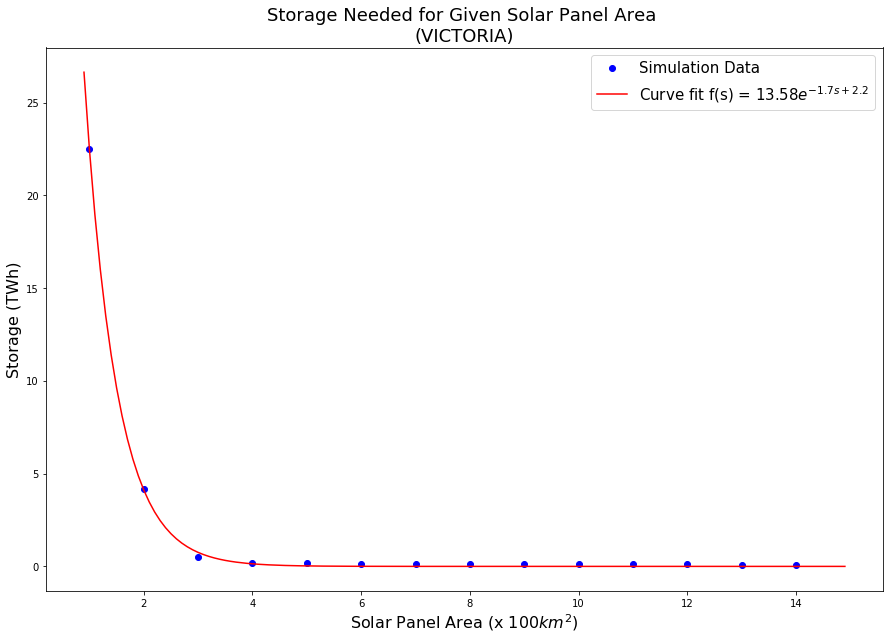

In [47]:
plt.figure(figsize=(15,10))
plt.plot(xData, yData, 'bo', label='Simulation Data')
plt.plot(np.arange(0.9,15, 0.1), 
         fitting_func(np.arange(0.9,15, 0.1), *popt), 
         color='red', 
         label='Curve fit f(s) = 13.58$e^{-1.7s+2.2}$')
plt.title('Storage Needed for Given Solar Panel Area \n(VICTORIA)', size=18)
plt.xlabel('Solar Panel Area (x 100$km^2$)', size=16)
plt.ylabel('Storage (TWh)', size=16)
plt.legend(prop={'size':15})
plt.savefig('VIC_solar_storage_relationship')

Now to analyse Queensland

In [48]:
days_energy = []
hhour_energy = [0]
day_areas = []
length = len(QLD)
i = 0
while i < length-1:
    x1 = QLD['HOUR'].iloc[i]
    x2 = QLD['HOUR'].iloc[i+1]
    y1 = QLD['MW'].iloc[i]
    y2 = QLD['MW'].iloc[i+1]
    if x1 != 24:
        area = area_under(x1,y1,x2,y2)
        day_areas.append(area)
    elif x1 == 24:
        day = QLD['DATE'].iloc[i]
        daily_energy = sum(day_areas)
        days_energy.append(daily_energy)
        day_areas = []
        x1 = 0
        area = area_under(x1,y1,x2,y2)
        day_areas.append(area)
    hhour_energy.append(area)   
    i += 1

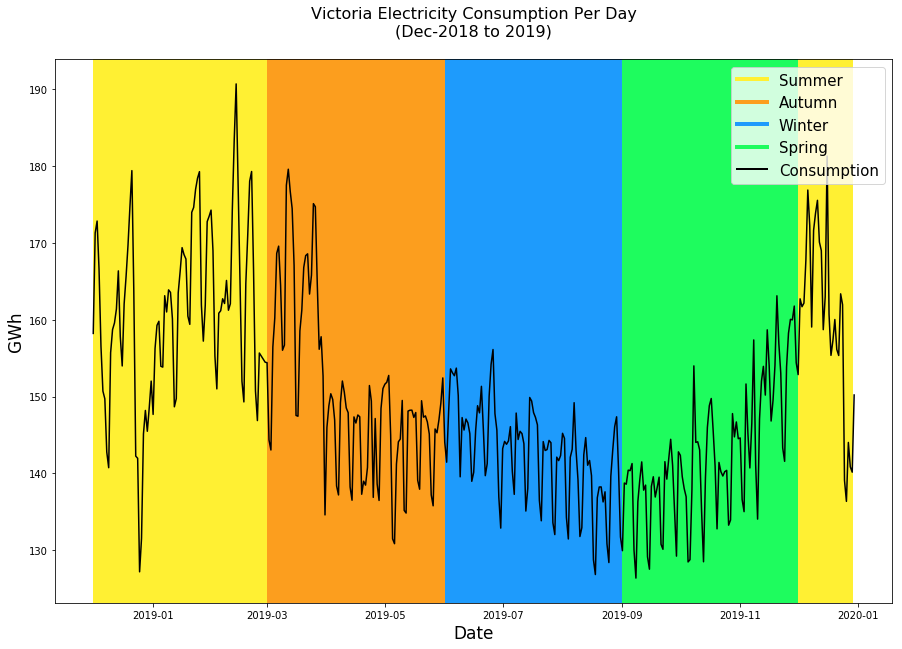

In [50]:
days_energy_GWh = [i/1000 for i in days_energy] # make list with GWh not MWh
plt.figure(figsize=(15,10))
plt.plot(dates[:-1], days_energy_GWh, color='black')
plt.title('Victoria Electricity Consumption Per Day\n(Dec-2018 to 2019)\n', size=16)
plt.xlabel('Date', size=17)
plt.ylabel('GWh', size=17)

plt.axvspan(d1, autumn, color='#FFF033')
plt.axvspan(autumn, winter, color='#FC9E1E')
plt.axvspan(winter, spring, color='#1E9BFC')
plt.axvspan(spring, summer, color='#1EFC5E')
plt.axvspan(summer, d_last, color='#FFF033')

legend_lines = [Line2D([0],[0], color='#FFF033', lw=4),
                Line2D([0],[0], color='#FC9E1E', lw=4),
                Line2D([0],[0], color='#1E9BFC', lw=4),
                Line2D([0],[0], color='#1EFC5E', lw=4), 
                Line2D([0],[0], color='black', lw=2)]
plt.legend(legend_lines, ['Summer', 'Autumn', 'Winter', 'Spring', 'Consumption'], prop={'size':15}, loc=1)
plt.savefig('QLD_daily_consumption')

Queensland Daylight Hours

In [51]:
sun_times = open('brisbane_sunrise_sunset_times.txt', 'r', encoding='utf-8').read()

In [52]:
sun_times = sun_times.splitlines()

In [53]:
'''
for each day on the year, strip the sunrise and sunset times, 
convert to 24 decimal time and add to year_times list
'''
year_times = []
for row in sun_times:
    if len(row) != 0:
        day_times = times_strip(row)
        year_times.append(day_times)

In [54]:
day_lengths = [i[2] for i in year_times]
day_lengths = pd.Series(day_lengths)
# day_lengths = day_lengths[]

In [55]:
nights_energy = []
night_areas = []
QLD_minus_half_first = QLD.iloc[24:] # drop first half of first day as I only have data for half that night
length = len(QLD)
i = 0
j = 0
for i in range(length):
    if i+1 < length and j+1 < len(year_times):
        x1 = QLD_minus_half_first['HOUR'].iloc[i]
        x2 = QLD_minus_half_first['HOUR'].iloc[i+1]
        y1 = QLD_minus_half_first['MW'].iloc[i]
        y2 = QLD_minus_half_first['MW'].iloc[i+1]
        sunset = year_times[j][1]
        sunrise = year_times[j+1][0]
        if x1 == 24:
            x1 = 0
        if x1 > sunset or x2 < sunrise:
            area = area_under(x1,y1,x2,y2)
            night_areas.append(area)
        elif x1 > sunrise:
            if len(night_areas) > 0:
                n_energy = sum(night_areas)
                nights_energy.append(n_energy)
                night_areas = []
                j += 1
        i += 1
    print(i, end='\r')

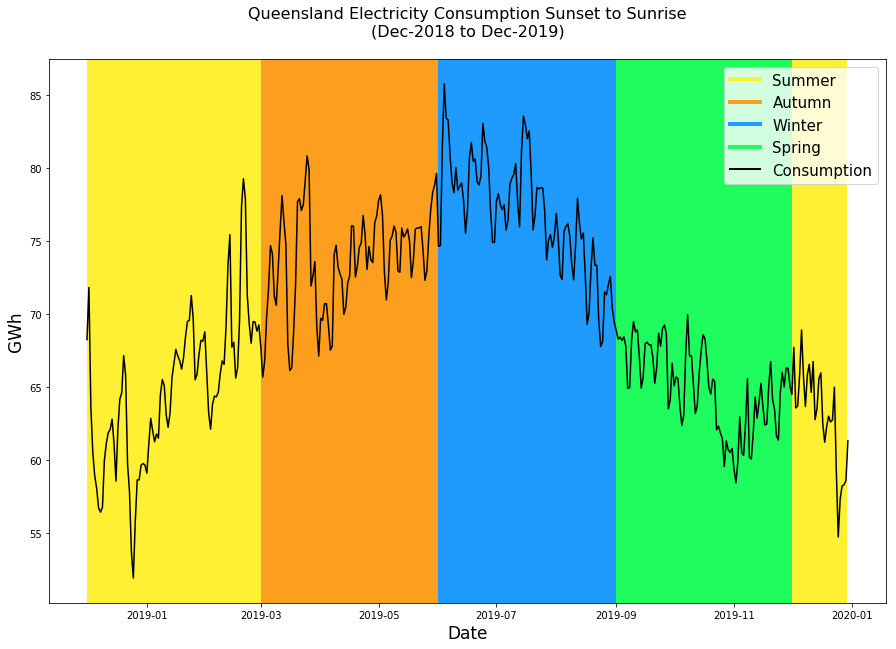

In [56]:
nights_energy_GWh = [i/1000 for i in nights_energy] # make list with GWh not MWh
plt.figure(figsize=(15,10))
plt.plot(dates[:-1], nights_energy_GWh, color='black')
plt.title('Queensland Electricity Consumption Sunset to Sunrise\n(Dec-2018 to Dec-2019)\n', size=16)
plt.xlabel('Date', size=17)
plt.ylabel('GWh', size=17)

plt.axvspan(d1, autumn, color='#FFF033')
plt.axvspan(autumn, winter, color='#FC9E1E')
plt.axvspan(winter, spring, color='#1E9BFC')
plt.axvspan(spring, summer, color='#1EFC5E')
plt.axvspan(summer, d_last, color='#FFF033')

legend_lines = [Line2D([0],[0], color='#FFF033', lw=4),
                Line2D([0],[0], color='#FC9E1E', lw=4),
                Line2D([0],[0], color='#1E9BFC', lw=4),
                Line2D([0],[0], color='#1EFC5E', lw=4), 
                Line2D([0],[0], color='black', lw=2)]
plt.legend(legend_lines, ['Summer', 'Autumn', 'Winter', 'Spring', 'Consumption'], prop={'size':15}, loc=1)
plt.savefig('QLD_night_consumption')

In [57]:
daytimes_energy = []
daytime_areas = []
length = len(QLD)
i = 0
j = 0
for i in range(length):
    if i+1 < length:
        x1 = QLD['HOUR'].iloc[i]
        x2 = QLD['HOUR'].iloc[i+1]
        y1 = QLD['MW'].iloc[i]
        y2 = QLD['MW'].iloc[i+1]
        sunset = year_times[j][1]
        sunrise = year_times[j][0]
        if x1 == 24:
            x1=0
            j += 1
        if x1 > sunrise and x2 < sunset:
            area = area_under(x1,y1,x2,y2)
            daytime_areas.append(area)
        elif x1 > sunset:
            if len(daytime_areas) > 0:
                d_energy = sum(daytime_areas)
                daytimes_energy.append(d_energy)
                daytime_areas = []
    i += 1
    print(i, end='\r')

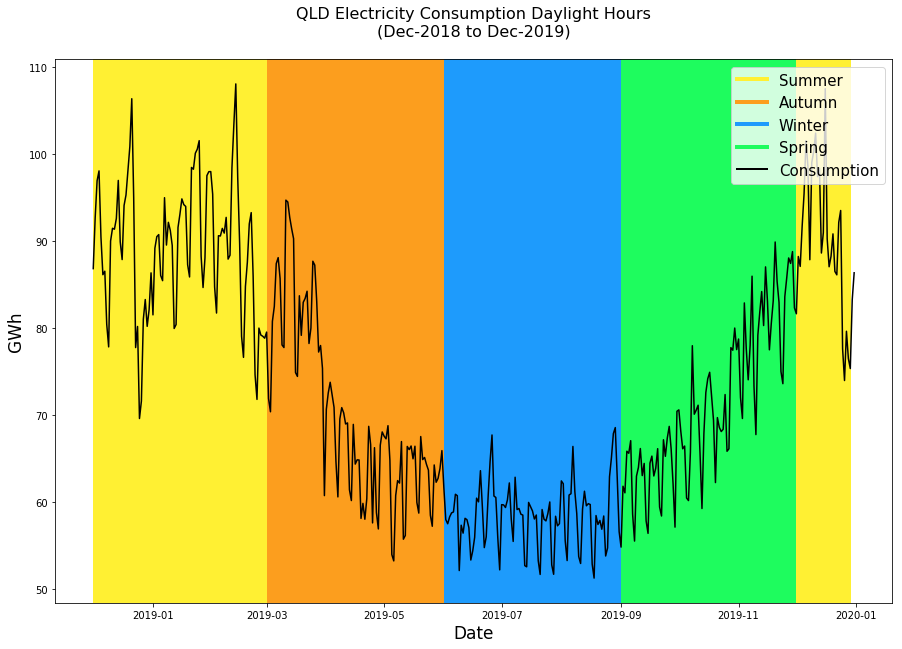

In [58]:
daytimes_energy_GWh = [i/1000 for i in daytimes_energy] # make list with GWh not MWh
dates = pd.unique(QLD['DATE'])
plt.figure(figsize=(15,10))
plt.plot(dates, daytimes_energy_GWh, color='black')
plt.title('QLD Electricity Consumption Daylight Hours\n(Dec-2018 to Dec-2019)\n', size=16)
plt.xlabel('Date', size=17)
plt.ylabel('GWh', size=17)

plt.axvspan(d1, autumn, color='#FFF033')
plt.axvspan(autumn, winter, color='#FC9E1E')
plt.axvspan(winter, spring, color='#1E9BFC')
plt.axvspan(spring, summer, color='#1EFC5E')
plt.axvspan(summer, d_last, color='#FFF033')

legend_lines = [Line2D([0],[0], color='#FFF033', lw=4),
                Line2D([0],[0], color='#FC9E1E', lw=4),
                Line2D([0],[0], color='#1E9BFC', lw=4),
                Line2D([0],[0], color='#1EFC5E', lw=4), 
                Line2D([0],[0], color='black', lw=2)]
plt.legend(legend_lines, ['Summer', 'Autumn', 'Winter', 'Spring', 'Consumption'], prop={'size':15}, loc=1)
plt.savefig('QLD_daylight_consumption')

In [59]:
solar_energy = pd.read_csv('solar_exposure_brisbane.csv')

In [60]:
# extract data for Dec 2018 to end of 2019
solar_energy = solar_energy.iloc[10561:10957] 

In [61]:
# rename column
solar_energy = solar_energy.rename(columns={'Daily global solar exposure (MJ/m*m)':'Solar'})

In [62]:
solar_energy = solar_energy.reset_index()

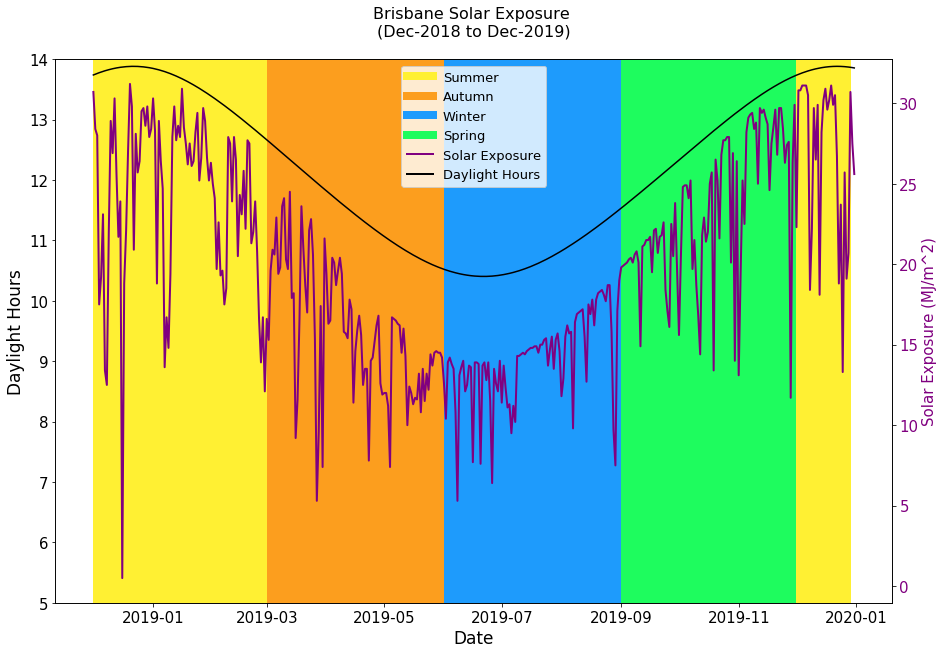

In [63]:
fig, ax1 = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(15)


ax1.plot(dates, day_lengths, color='black')
ax1.set_title('Brisbane Solar Exposure \n(Dec-2018 to Dec-2019)\n', size=16)
ax1.set_xlabel('Date', size=17)
ax1.set_ylabel('Daylight Hours', size=17)
ax1.set_ylim([5,14])
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax1.axvspan(d1, autumn, color='#FFF033')
ax1.axvspan(autumn, winter, color='#FC9E1E')
ax1.axvspan(winter, spring, color='#1E9BFC')
ax1.axvspan(spring, summer, color='#1EFC5E')
ax1.axvspan(summer, d_last, color='#FFF033')

ax2 = ax1.twinx()

ax2.set_ylabel('Solar Exposure (MJ/m^2)', color='purple', size=15)
ax2.plot(dates, solar_energy['Solar'], color='purple', lw=2)
ax2.tick_params(axis='y', labelcolor='purple', labelsize=15)

legend_lines = [Line2D([0],[0], color='#FFF033', lw=8),
                Line2D([0],[0], color='#FC9E1E', lw=8),
                Line2D([0],[0], color='#1E9BFC', lw=8),
                Line2D([0],[0], color='#1EFC5E', lw=8),
                Line2D([0],[0], color='purple', lw=2),
                Line2D([0],[0], color='black', lw=2)]
                       
ax1.legend(legend_lines, 
           ['Summer', 'Autumn', 'Winter', 'Spring', 'Solar Exposure', 'Daylight Hours'],
           loc=9, 
           prop={'size':13})
plt.savefig('brisbane_solar_exposure_year')

In [110]:
solar_sq_km_list = []
for i in np.arange(1,15,0.1):
    s = round(i,1)*100
    solar_sq_km_list.append(s)

In [111]:
list_of_dfs = []
for sq_km in solar_sq_km_list:
    df = pd.DataFrame(data={'Date':dates[:-1],
                            'Day_demand':daytimes_energy[:-1], 
                            'Night_demand':nights_energy, 
                            'Solar_exposure':solar_energy['Solar'].iloc[:-1]}
                            )
    list_of_dfs.append(df)

In [112]:
list_of_sqkm_df_tuples = list(zip(solar_sq_km_list,list_of_dfs))

In [113]:
max_amount_of_storage = sum(days_energy) # amount of storage needed to run without any solar

In [114]:
min_amount_of_storage = max(nights_energy)

In [115]:
def QLD_solar_storage_function(solar_sq_km, df):  
    upper_bound = max_amount_of_storage
    lower_bound = min_amount_of_storage
    max_storage_level = 10_000_000
    print(solar_sq_km)
    df['Production'] = (df['Solar_exposure'] * solar_sq_km  * 0.2 * 1000000 * 0.000278) #convert from MJ to MWh
    df['day_net'] = df['Production'] - df['Day_demand']
    df['Storage_level_end_of_day'] = 0
    df['Storage_level_end_of_night'] = 0
    storage_level_end_of_night = max_storage_level * 0.5 # start with 50% capacity
    k = len(df)
    while lower_bound != max_storage_level != upper_bound:
        i = 0
        while i < len(df):
            day_net_demand = df['day_net'].iloc[i]
            night_demand = df['Night_demand'].iloc[i]
            storage_level_end_of_day = storage_level_end_of_night + day_net_demand
            if storage_level_end_of_day > max_storage_level:
                storage_level_end_of_day = max_storage_level
                df['Storage_level_end_of_day'].iloc[i] = storage_level_end_of_day
            else:
                df['Storage_level_end_of_day'].iloc[i] = storage_level_end_of_day

            storage_level_end_of_night = storage_level_end_of_day - night_demand
            if storage_level_end_of_night > 0:
                df['Storage_level_end_of_night'].iloc[i] = storage_level_end_of_night
            else:
                lower_bound = max_storage_level
                max_storage_level = upper_bound - (upper_bound - max_storage_level)/2
                storage_level_end_of_night = max_storage_level * 0.5
                i = 0 
            i+=1
        if round(lower_bound,-2) != round(max_storage_level, -2) != round(upper_bound, -2):
            upper_bound = max_storage_level
            max_storage_level = upper_bound - (upper_bound - lower_bound)/2
        else:
            lower_bound = round(lower_bound,-2)
            max_storage_level = round(max_storage_level, -2)
            upper_bound = round(upper_bound, -2)
    return solar_sq_km, max_storage_level, df

In [100]:
# sqkm_storage_file = open('./simulation_results/QLD/sqkm_storage_file.csv', 'w')
# sqkm_storage_file.write('solar-exposure,storage\n')
# sqkm_storage_file.close()

In [116]:
sqkm_storage_file = open('./simulation_results/QLD/sqkm_storage_file.csv', 'a')
start = time.perf_counter()
with concurrent.futures.ProcessPoolExecutor() as executor:
    
    results = [executor.submit(QLD_solar_storage_function, elem[0], elem[1]) for elem in list_of_sqkm_df_tuples]
    
    for f in concurrent.futures.as_completed(results):
        print(f.result()[:2])
        sqkm_storage_file.write(f'{f.result()[0]},{f.result()[1]}\n')
        csv_name = f'{f.result()[0]}sqkm_df.csv'
        f.result()[2].to_csv(r'./simulation_results/QLD/'+csv_name)
        print(f'Saved {csv_name}...')
        
    
finish = time.perf_counter()
sqkm_storage_file.close()

print(f'Finished in {round(finish-start,2)} second(s)')

100.0
130.0
110.00000000000001
120.0
140.0
(100.0, 26396900.0)
Saved 100.0sqkm_df.csv...
150.0
(120.0, 14099200.0)
Saved 120.0sqkm_df.csv...
160.0
(110.00000000000001, 26396900.0)
Saved 110.00000000000001sqkm_df.csv...
170.0
(130.0, 7521500.0)
Saved 130.0sqkm_df.csv...
180.0
(140.0, 4538900.0)
Saved 140.0sqkm_df.csv...
190.0
(160.0, 2225300.0)
Saved 160.0sqkm_df.csv...
200.0
(150.0, 3228100.0)
Saved 150.0sqkm_df.csv...
210.0
(170.0, 1461000.0)
Saved 170.0sqkm_df.csv...
220.00000000000003
(180.0, 918000.0)
Saved 180.0sqkm_df.csv...
229.99999999999997
(190.0, 527200.0)
Saved 190.0sqkm_df.csv...
240.0
(210.0, 217400.0)
Saved 210.0sqkm_df.csv...
250.0
(200.0, 247300.0)
Saved 200.0sqkm_df.csv...
260.0
270.0
(229.99999999999997, 201200.0)
Saved 229.99999999999997sqkm_df.csv...
(220.00000000000003, 202500.0)
Saved 220.00000000000003sqkm_df.csv...
280.0
290.0
(250.0, 200600.0)
Saved 250.0sqkm_df.csv...
(240.0, 200900.0)
Saved 240.0sqkm_df.csv...
300.0
310.0
(270.0, 200100.0)
Saved 270.0sqkm_df

In [20]:
sqkm_storage_qld = pd.read_csv('./simulation_results/QLD/sqkm_storage_file.csv')

In [25]:
sqkm_storage_qld

,solar-exposure,storage
0,100.0,26396900.0
1,120.0,14099200.0
2,110.0,26396900.0
3,130.0,7521500.0
4,140.0,4538900.0
5,160.0,2225300.0
6,150.0,3228100.0
7,170.0,1461000.0
8,180.0,918000.0
9,190.0,527200.0


In [14]:
sqkm_storage_qld = sqkm_storage_qld.sort_values(by='solar-exposure')

In [22]:
xData = sqkm_storage_qld['solar-exposure']/100
yData = sqkm_storage_qld['storage']/1_000_000

In [23]:
popt, pcov = curve_fit(fitting_func, xData, yData)
print(popt)

[ 4.14982178 -3.89365569  5.86158698]


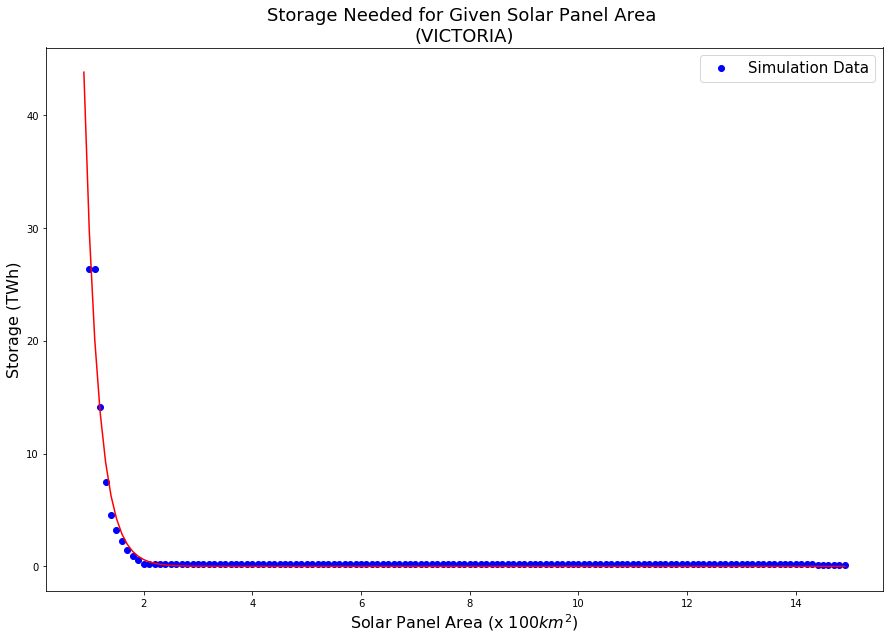

In [24]:
plt.figure(figsize=(15,10))
plt.plot(xData, yData, 'bo', label='Simulation Data')
plt.plot(np.arange(0.9,15, 0.1), 
         fitting_func(np.arange(0.9,15, 0.1), *popt), 
         color='red')
plt.title('Storage Needed for Given Solar Panel Area \n(VICTORIA)', size=18)
plt.xlabel('Solar Panel Area (x 100$km^2$)', size=16)
plt.ylabel('Storage (TWh)', size=16)
plt.legend(prop={'size':15})
plt.savefig('VIC_solar_storage_relationship')